<a href="https://colab.research.google.com/github/Harinipraveen/Arcada-ML-projects/blob/master/patent_bigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install --upgrade google-cloud-bigquery

In [0]:
#!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

In [0]:
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\Harini Pravin\Downloads\My First Project-afe1694bf25a.json'

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
project_id = 'brave-iterator-235513'
from google.cloud.bigquery.client import Client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
pat_dataset_ref = client.dataset('google_patents_research', project='patents-public-data')
pat_dset = client.get_dataset(pat_dataset_ref)

In [8]:
[x.table_id for x in client.list_tables(pat_dset)]

['publications',
 'publications_201710',
 'publications_201802',
 'publications_201809']

In [0]:
#table_ref = pat_dataset_ref.table("publications_201802")
#table = client.get_table(table_ref)
#df = client.list_rows(table).to_dataframe()
#df = client.query(sql).to_dataframe()

In [10]:
sample_count = 200000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `patents-public-data.google_patents_research.publications_201802`''').to_dataframe().total[0]

patent = client.query('''
  SELECT
    *
  FROM
    `patents-public-data.google_patents_research.publications_201802`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)
print('our sampled dataset has %d rows' % sample_count)

Full dataset has 96018448 rows
our sampled dataset has 200000 rows


In [11]:
job_config = bigquery.QueryJobConfig()
job_config.dry_run = True
job_config.use_query_cache = False
query_job = client.query(
    (
        '''
  SELECT
    *
  FROM
    `patents-public-data.google_patents_research.publications_201802`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)
    ),
    job_config=job_config,
)  # API request

# A dry run query completes immediately.
assert query_job.state == "DONE"
assert query_job.dry_run

print("This query processed {} bytes.".format(query_job.total_bytes_processed))

This query processed 240130957742 bytes.


In [12]:
patent.head()

,publication_number,title,title_translated,abstract,abstract_translated,cpc,cpc_low,cpc_inventive_low,top_terms,similar,url,country,publication_description,cited_by,embedding_v1
0,LU-24773-A,,False,,False,[],[],[],[],[],https://patents.google.com/patent/LU24773A,LUXEMBOURG,,[],[]
1,ES-492232-D0,,False,,False,[],[],[],[],[],https://patents.google.com/patent/ES492232D0,SPAIN,Patent application filed,[],[]
2,BE-823583-A1,,False,,False,[],[],[],[],[],https://patents.google.com/patent/BE823583A1,BELGIUM,Patent of invention in French,[],[]
3,BE-599023-A1,,False,,False,[],[],[],[],[],https://patents.google.com/patent/BE599023A1,BELGIUM,Patent of invention in French,[],[]
4,RU-2421199-C2,Method for prevention of silicone oil reflux i...,False,FIELD: medicine. \n SUBSTANCE: offered is ...,False,[],[],[],"[chamber, silicone, oil, anterior, method, ext...","[{'publication_number': 'US-4331130-A', 'appli...",https://patents.google.com/patent/RU2421199C2,RUSSIAN FEDERATION,Patent for invention (second publication),[],"[-0.08524717, -0.25698438, 0.05691113, -0.1336..."


In [13]:
patent['publication_description'].value_counts()

Published unexamined patent application                                                25570
Patent                                                                                 18565
Unexaminded application                                                                15830
Registered utility model                                                               11265
Patent application publication                                                         10623
Published unexamined utility model application                                          7873
Published granted patent (Second level)                                                 7723
Patent ( having previously published pre-grant publication)                             6115
Granted patent                                                                          6112
International application published with international search report                    5474
Patent specification                                                  

In [14]:
patent.drop(['title_translated','abstract','abstract_translated','cpc','cpc_low','cpc_inventive_low','similar','url','cited_by','embedding_v1'],1,inplace=True)
patent.columns

Index(['publication_number', 'title', 'top_terms', 'country',
       'publication_description'],
      dtype='object')

In [0]:
patent = patent.groupby('publication_description').filter(lambda x: len(x) > 1000)

In [16]:
patent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179435 entries, 20723 to 200157
Data columns (total 5 columns):
publication_number         179435 non-null object
title                      179435 non-null object
top_terms                  179435 non-null object
country                    179435 non-null object
publication_description    179435 non-null object
dtypes: object(5)
memory usage: 8.2+ MB


In [17]:
patent.isnull().values.any()

False

In [18]:
patent['country'].value_counts()

JAPAN                       50527
CHINA                       35403
USA                         32382
EUROPEAN PATENT OFFICE      12647
FEDERAL REPUBLIC GERMANY    12014
REPUBLIC OF KOREA            8222
UNITED KINGDOM               7798
WIPO (PCT)                   6672
CANADA                       6356
FRANCE                       5836
BELGIUM                      1191
FINLAND                       195
RUSSIAN FEDERATION            172
SPAIN                          11
NETHERLANDS                     9
Name: country, dtype: int64

In [19]:
patent['publication_description'].value_counts()

Published unexamined patent application                                         25570
Patent                                                                          18565
Unexaminded application                                                         15830
Registered utility model                                                        11265
Patent application publication                                                  10623
Published unexamined utility model application                                   7873
Published granted patent (Second level)                                          7723
Patent ( having previously published pre-grant publication)                      6115
Granted patent                                                                   6112
International application published with international search report             5474
Patent specification                                                             5063
Publication of application with search report         

[Text(0, 0, 'FEDERAL REPUBLIC GERMANY'),
 Text(0, 0, 'CANADA'),
 Text(0, 0, 'USA'),
 Text(0, 0, 'RUSSIAN FEDERATION'),
 Text(0, 0, 'CHINA'),
 Text(0, 0, 'JAPAN'),
 Text(0, 0, 'EUROPEAN PATENT OFFICE'),
 Text(0, 0, 'FINLAND'),
 Text(0, 0, 'NETHERLANDS'),
 Text(0, 0, 'BELGIUM'),
 Text(0, 0, 'REPUBLIC OF KOREA'),
 Text(0, 0, 'UNITED KINGDOM'),
 Text(0, 0, 'SPAIN'),
 Text(0, 0, 'FRANCE'),
 Text(0, 0, 'WIPO (PCT)')]

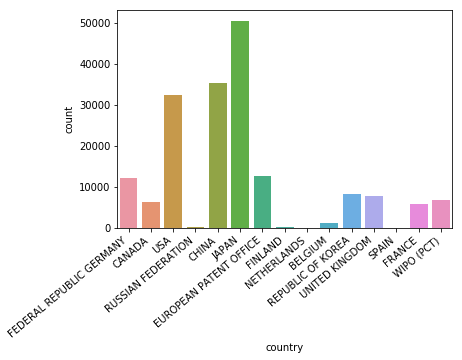

In [20]:

g = sns.countplot((patent['country']))
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [0]:
patent['publication_number'] = patent['publication_number'].str.replace(r"-","")

In [22]:
patent.head(10)

,publication_number,title,top_terms,country,publication_description
20723,DE291380C,,[],FEDERAL REPUBLIC GERMANY,Patent
20724,DE256728C,,[],FEDERAL REPUBLIC GERMANY,Patent
20725,CA1317998C,Electromagnetic contactor with lightweight wid...,"[current, voltage, magnetic, terminal, fig, in...",CANADA,Patent
20726,US1153177A,Cooker.,"[strip, cans, carrier, box, rest, pocket, ways...",USA,Patent
20727,US1423781A,Unbreakable cant hook,"[handle, end, hook, conical, pick, rod, bore, ...",USA,Patent
20728,US1967608A,Brick making machine,"[brick, machine, material, charger, making, mo...",USA,Patent
20729,US1050146A,Curtain for automobiles.,"[bow, front, curtain, canopy, seat, upper, sec...",USA,Patent
20730,US1263289A,Purifying gasolene fractions containing aromat...,"[acid, hydrocarbons, sulfuric, unsaturated, co...",USA,Patent
20731,US1597526A,Cartridge for fire extinguishers and the like,"[shell, gas, acid, cartridge, bottle, wire, sh...",USA,Patent
20732,US1508009A,Shaft hanger,"[leg, member, hanger, metal, transverse, sheet...",USA,Patent


In [0]:
import nltk

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import string
from nltk.corpus import stopwords

In [0]:
#stopwords.words('english')

In [0]:
def text_process(topic):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in topic if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [29]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(patent['publication_description'])
print('total number of vocab words:',len(bow_transformer.vocabulary_))
patent_bow = bow_transformer.transform(patent['publication_description'])
print('Shape of Sparse Matrix: ', patent_bow.shape)
print('Amount of Non-Zero occurences: ', patent_bow.nnz)

total number of vocab words: 52
Shape of Sparse Matrix:  (179435, 52)
Amount of Non-Zero occurences:  610372


In [0]:
tfidf_transformer = TfidfTransformer().fit(patent_bow)
patent_tfidf = tfidf_transformer.transform(patent_bow)

In [33]:
num_clusters = np.arange(2,10)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size).fit(patent_tfidf)
    predictions = model.predict(patent_tfidf)
    results[size] = davies_bouldin_score(patent_tfidf.toarray(), predictions)
  

best_size = max(results, key=results.get)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_di

In [34]:
print('The ideal number of clusters to be used based on DB index is {}:'.format(best_size))

The ideal number of clusters to be used based on DB index is 3:


In [0]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(patent_tfidf)
pred = kmeans.predict(patent_tfidf)

In [73]:
DBscore = davies_bouldin_score(patent_tfidf.toarray(), pred)
print('The DB index for cluster size of 3 is',DBscore)

The DB index for cluster size of 3 is 1.8121391933353765


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [0]:
patent['cls'] = pred

In [37]:
patent[patent['cls']==0]['publication_description'].value_counts()

Patent                                                         18565
Patent application publication                                 10623
Patent ( having previously published pre-grant publication)     6115
Patent specification                                            5063
Doc. laid open (first publication)                              3622
Patent of invention ( First publication)                        2640
Patent ( no pre-grant publication)                              1594
Patent of invention ( Second publication)                       1303
Laid open (first publication)                                   1241
Patent undefined                                                1191
Granted Patent                                                  1169
Name: publication_description, dtype: int64

In [43]:
print('The total no of patents in the first cluster', sum(patent['cls']==0))

The total no of patents in the first cluster 53126


In [44]:
patent[patent['cls']==0]

,publication_number,title,top_terms,country,publication_description,cls
20723,DE291380C,,[],FEDERAL REPUBLIC GERMANY,Patent,0
20724,DE256728C,,[],FEDERAL REPUBLIC GERMANY,Patent,0
20725,CA1317998C,Electromagnetic contactor with lightweight wid...,"[current, voltage, magnetic, terminal, fig, in...",CANADA,Patent,0
20726,US1153177A,Cooker.,"[strip, cans, carrier, box, rest, pocket, ways...",USA,Patent,0
20727,US1423781A,Unbreakable cant hook,"[handle, end, hook, conical, pick, rod, bore, ...",USA,Patent,0
20728,US1967608A,Brick making machine,"[brick, machine, material, charger, making, mo...",USA,Patent,0
20729,US1050146A,Curtain for automobiles.,"[bow, front, curtain, canopy, seat, upper, sec...",USA,Patent,0
20730,US1263289A,Purifying gasolene fractions containing aromat...,"[acid, hydrocarbons, sulfuric, unsaturated, co...",USA,Patent,0
20731,US1597526A,Cartridge for fire extinguishers and the like,"[shell, gas, acid, cartridge, bottle, wire, sh...",USA,Patent,0
20732,US1508009A,Shaft hanger,"[leg, member, hanger, metal, transverse, sheet...",USA,Patent,0


[Text(0, 0, 'Patent'),
 Text(0, 0, 'Granted Patent'),
 Text(0, 0, 'Patent undefined'),
 Text(0, 0, 'Patent specification'),
 Text(0, 0, 'Laid open (first publication)'),
 Text(0, 0, 'Patent application publication'),
 Text(0, 0, 'Doc. laid open (first publication)'),
 Text(0, 0, 'Patent ( no pre-grant publication)'),
 Text(0, 0, 'Patent of invention ( First publication)'),
 Text(0, 0, 'Patent of invention ( Second publication)'),
 Text(0, 0, 'Patent ( having previously published pre-grant publication)')]

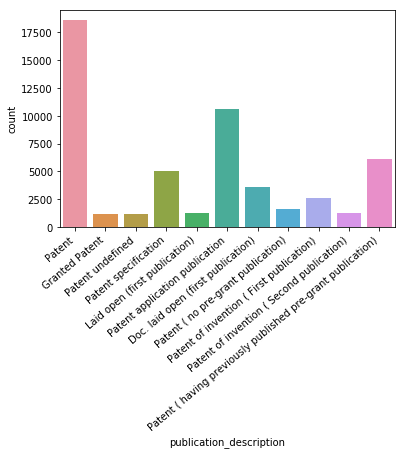

In [45]:

g = sns.countplot(patent[patent['cls']==0]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [46]:
patent[patent['cls']==1]['publication_description'].value_counts()

Registered utility model                               11265
Published unexamined utility model application          7873
Utility model                                           3008
Granted utility model                                   2676
Published utility model registration (Second level)     2258
Name: publication_description, dtype: int64

In [47]:
print('The total no of patents in the first cluster', sum(patent['cls']==1))

The total no of patents in the first cluster 27080


In [48]:
patent[patent['cls']==1]

,publication_number,title,top_terms,country,publication_description,cls
47780,DE1485887U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47781,DE7416985U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47782,DE202015003566U1,Apparatus for determining the fundamental freq...,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47783,DE1797361U,"Apparatus for maintaining a gas, particularly ...",[],FEDERAL REPUBLIC GERMANY,Utility model,1
47784,DE202004009132U1,Boiler and roasting furnace with integral pyro...,"[reactor, system, insulation, internal, water,...",FEDERAL REPUBLIC GERMANY,Utility model,1
47785,DE6912388U,Contact performing from korrosionsbestaendigen...,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47786,DE20212285U1,Air cleaning device,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47787,DE1488076U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47788,DE1313340U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47789,DE1427625U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1


[Text(0, 0, 'Utility model '),
 Text(0, 0, 'Granted utility model'),
 Text(0, 0, 'Registered utility model'),
 Text(0, 0, 'Published unexamined utility model application'),
 Text(0, 0, 'Published utility model registration (Second level)')]

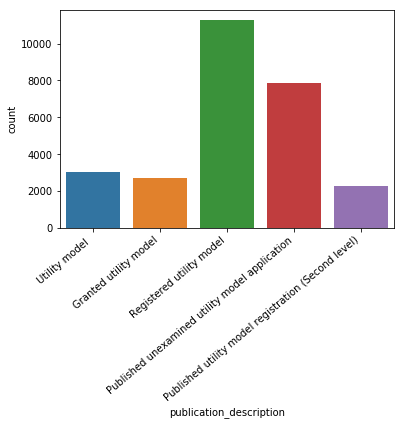

In [49]:

g = sns.countplot(patent[patent['cls']==1]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [50]:
patent[patent['cls']==2]['publication_description'].value_counts()

Published unexamined patent application                                         25570
Unexaminded application                                                         15830
Published granted patent (Second level)                                          7723
Granted patent                                                                   6112
International application published with international search report             5474
Publication of application with search report                                    4838
Official gazette of the unexamined patents                                       4591
Granted patent for invention                                                     4463
Published patent application                                                     4331
Laid-open patent application                                                     2758
Published examined patent application (Second level)                             2717
Granted EP number in Bulletin                         

In [51]:
print('The total no of patents in the first cluster', sum(patent['cls']==2))

The total no of patents in the first cluster 99229


In [52]:
patent[patent['cls']==2]

,publication_number,title,top_terms,country,publication_description,cls
39288,USD457241S,Skin wound closure,"[view, fig, design, wound, shown, closure, sid...",USA,Design patent,2
39289,USD675540S,Paint syringe,"[syringe, paint, view, fig, front, design, ele...",USA,Design patent,2
39290,USD507919S,Dual bedding set,"[view, fig, set, bedding, dual, shown, perspec...",USA,Design patent,2
39291,USD397482S,Wall luminaire,"[view, fig, side, luminaire, wall, design, ima...",USA,Design patent,2
39292,USD737733S,Stroller,"[fig, view, elevational, stroller, design, sid...",USA,Design patent,2
39293,USD374006S,Mobile telephone,"[view, fig, side, telephone, mobile, design, a...",USA,Design patent,2
39294,USD307462S,Grease filter for use in restaurants or the like,"[view, fig, elevational, filter, restaurants, ...",USA,Design patent,2
39295,USD691138S,Stylus pen for a mobile device,"[fig, view, pen, device, stylus, mobile, desig...",USA,Design patent,2
39296,USD283242S,Soaring fireworks,"[fig, fireworks, soaring, view, shown, elevati...",USA,Design patent,2
39297,USD587672S,Portable telephone,"[fig, view, elevational, telephone, portable, ...",USA,Design patent,2


[Text(0, 0, 'Design patent'),
 Text(0, 0, 'Granted patent'),
 Text(0, 0, 'Application for patent'),
 Text(0, 0, 'Unexaminded application'),
 Text(0, 0, 'Laid-open patent application'),
 Text(0, 0, 'Published patent application'),
 Text(0, 0, 'Granted EP number in Bulletin'),
 Text(0, 0, 'Granted patent for invention '),
 Text(0, 0, 'Separately published search report'),
 Text(0, 0, 'Published granted patent (Second level)'),
 Text(0, 0, 'Published unexamined patent application'),
 Text(0, 0, 'Official gazette of the unexamined patents'),
 Text(0, 0, 'Publication of application with search report'),
 Text(0, 0, 'Separately published supplemental search report'),
 Text(0, 0, 'Later publication of ISR with revised front page'),
 Text(0, 0, 'Publication of application without search report'),
 Text(0, 0, 'Published examined patent application (Second level)'),
 Text(0, 0, 'Application for patent of invention ( First publication)'),
 Text(0, 0, 'International application published with inte

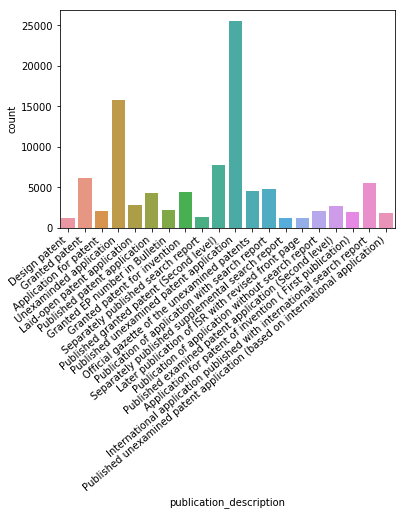

In [53]:

g = sns.countplot(patent[patent['cls']==2]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")